In [ ]:
"""
some code is adapted from https://github.com/shruti-jadon/Covid-19-Detection-Few-Shot-Learning.
"""


import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Covid-19-Detection-Few-Shot-Learning")

# %tensorflow_version 1.x

In [ ]:
!python -m pip install pyradiomics


     |████████████████████████████████| 188 kB 5.2 MB/s 
     |████████████████████████████████| 48.4 MB 75 kB/s 
     |████████████████████████████████| 108 kB 57.0 MB/s 
     |████████████████████████████████| 546 kB 40.2 MB/s 


In [ ]:
# -*- encoding: utf-8 -*-
import argparse
import torch
import torchvision.datasets as dsets
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision import transforms
import pickle
import torch
import torch.nn as nn
from glob import glob
import cv2
import os
%matplotlib inline
# os.remove('./train/b37a7290d957 (1).jpg')

# prepare data

In [ ]:

train_path = "./cropped_train"
test_path = "./cropped_test"

# dir = './train'
# onlyfiles = next(os.walk(dir))[2]
# print(len(onlyfiles))
def class_to_label(label):
  class_label = 0
  if label == "negative":
    class_label = 0
  elif label == "typical":
    class_label = 1
  elif label == "indeterminate":
    class_label = 1
  else:
    class_label = 1

  return class_label

def load_data(is_train):
  if is_train:
    paths = glob(os.path.join(train_path, '*.jpg'))
    print("total train: " + str(len(paths)))
  else:
    paths = glob(os.path.join(test_path, '*.jpg'))
    print("total test: " + str(len(paths)))
  
  return paths


def read_file(is_train):
  labels = []
  if is_train:
    with open("./train.txt") as f:
      for line in f:
        line = line.split(" ")
        labels.append({"img": line[1], "cls": line[2]})
  else:
    with open("./test.txt") as f:
      for line in f:
        line = line.split(" ")
        labels.append({"img": line[1], "cls": line[2]})
  return labels


files_train = read_file(True)

data_train = load_data(True)
# print(data_train)
imgs_train = np.zeros(shape=[4500, 224, 224, 3])
labels_train = np.zeros(shape=[4500])

for i, d in enumerate(data_train):
  img = cv2.imread(d)
  img = cv2.resize(img, (224, 224))
  imgs_train[i] = img
  # print(d)
  for file in files_train:
    if file["img"] == d[16:]:
      # print(1)
      # print(file["cls"])
      label = class_to_label(file["cls"])
      labels_train[i] = label
      break
# print(labels_train)
print(imgs_train.shape, labels_train.shape)


# np.ndarray.astype(self.x_tr, np.float32)


files_test = read_file(False)
data_test = load_data(False)
# print(data_train[:5])
imgs_test = np.zeros(shape=[1834, 224, 224, 3])
labels_test = np.zeros(shape=[1834])

for i, d in enumerate(data_test):
  img = cv2.imread(d)
  img = cv2.resize(img, (224, 224))
  imgs_test[i] = img
  for file in files_test:
    if file["img"] == d[15:]:
      # print(1)
      label = class_to_label(file["cls"])
      # print(label)
      labels_test[i] = label
      break
# print(labels_test)
print(imgs_test.shape, labels_test.shape)

d_train = {
  "x_train": imgs_train,
  "y_train": labels_train
}
np.savez("train_lung_bi.npz", **d_train)
d_test = {
  "x_test": imgs_test,
  "y_test": labels_test
}
np.savez("test_lung_bi.npz", **d_test)

total train: 4500
(4500, 224, 224, 3) (4500,)
total test: 1834
(1834, 224, 224, 3) (1834,)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.utils import shuffle
from glob import glob
import pandas as pd
import cv2
import os
import numpy as np


class Dataset(object):

    def __init__(self, normalize=True):

        print("\nInitializing Dataset...")

        self.normalize = normalize

        # (x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.mnist.load_data()
        # read images.
        data = self.load_data()
        # read labels.
        df = pd.read_csv("./features_v4.csv")
        classes = df[['id', 'class']]
        # print(classes)
        imgs = np.zeros(shape=[6334, 224, 224, 3])
        labels = np.zeros(shape=[6334])
        for i, d in enumerate(data):
            img = cv2.imread(d)
            # print(img.shape)
            img = cv2.resize(img, (224, 224))
            # img = exposure.equalize_adapthist(img/255, clip_limit=0.05, kernel_size=24) * 255
            imgs[i] = img
            # print(d)
            # cls = classes[classes["id"] == d[-16:-4]]
            cls = classes[classes["id"] == d[-16:-4]]
            label = str(cls["class"][:4]).split(" ")[4][0]
            # print(label)
            # print(cls['label'])
            # print(str(cls['label'][:4]).split(" ")[4])
            # if str(cls['label'][:4]).split(" ")[4] == "none":

            #     label = 1
            # else:
            #     label = 0
            # label = classes[classes["id"] == d[-16:-4]]['Negative for Pneumonia'].values[0]
            # print(label)
            labels[i] = int(label)
        
        print(imgs.shape)
        print(labels.shape)
        # print(labels[:100])
        # here we split 4500 samples for training, and 1834 for testing.
        self.x_tr, self.y_tr = imgs[:4500], labels[:4500]
        self.x_te, self.y_te = imgs[4500:], labels[4500:]

        self.x_tr = np.ndarray.astype(self.x_tr, np.float32)
        self.x_te = np.ndarray.astype(self.x_te, np.float32)

        self.split_dataset()

        self.num_tr, self.num_te = self.x_tr.shape[0], self.x_te.shape[0]
        self.idx_tr, self.idx_te = 0, 0

        print("Number of data\nTraining: %d, Test: %d\n" %(self.num_tr, self.num_te))

        x_sample, y_sample = self.x_te[0], self.y_te[0]
        self.height = x_sample.shape[0]
        self.width = x_sample.shape[1]
        try: self.channel = x_sample.shape[2]
        except: self.channel = 1

        self.min_val, self.max_val = x_sample.min(), x_sample.max()
        # self.num_class = (y_te.max()+1)
        self.num_class = 2

        print("Information of data")
        print("Shape  Height: %d, Width: %d, Channel: %d" %(self.height, self.width, self.channel))
        print("Value  Min: %.3f, Max: %.3f" %(self.min_val, self.max_val))
        print("Class  %d" %(self.num_class))
        print("Normalization: %r" %(self.normalize))
        if(self.normalize): print("(from %.3f-%.3f to %.3f-%.3f)" %(self.min_val, self.max_val, 0, 1))

        data_train = {
          "x_train": self.x_tr,
          "y_train": self.y_tr
        }
        np.savez("train_lung.npz", **data_train)
        data_test = {
          "x_test": self.x_te,
          "y_test": self.y_te
        }
        np.savez("test_lung.npz", **data_test)

    def split_dataset(self):
        # all images and labels.
        x_total = np.append(self.x_tr, self.x_te, axis=0)
        y_total = np.append(self.y_tr, self.y_te, axis=0)

        x_normal, y_normal = [], []
        x_abnormal, y_abnormal = [], []
        # for all labels.
        for yidx, y in enumerate(y_total):

            y_tmp = np.expand_dims(y_total[yidx], axis=0)

            if(y == 1):     # as normal
                x_normal.append(x_total[yidx])
                y_normal.append(y_tmp)
            else:   # as abnormal
                x_abnormal.append(x_total[yidx])
                y_abnormal.append(y_tmp)

            # if((len(x_normal) >= 2000) and len(x_abnormal) >= 2000): break
        # print(len(x_normal), len(y_normal))
        # print(len(x_abnormal), len(y_abnormal))

        # x_normal, y_normal = x_normal[:2000], y_normal[:2000]
        # x_abnormal, y_abnormal = x_abnormal[:2000], y_abnormal[:2000]

        # We take all data instead.
        x_normal = np.asarray(x_normal)
        y_normal = np.asarray(y_normal)
        x_abnormal = np.asarray(x_abnormal)
        y_abnormal = np.asarray(y_abnormal)

        # for penalty term adjust training set only.
        # Normal: 1, Abnormal: 0
        # for 2040 normal data, we give 1200 for training and 840 for testing.
        self.x_tr, self.y_tr = x_normal[:1200], y_normal[:1200]
        self.x_te, self.y_te = x_normal[1200:], y_normal[1200:]
        # for 4294 abnormal data, we give 3300 for training and 994 for testing.
        self.x_tr = np.append(self.x_tr, x_abnormal[:3300], axis=0)
        self.y_tr = np.append(self.y_tr, y_abnormal[:3300], axis=0)

        self.x_te = np.append(self.x_te, x_abnormal[3300:], axis=0)
        self.y_te = np.append(self.y_te, y_abnormal[3300:], axis=0)

        print(self.x_tr.shape, self.y_tr.shape)
        print(self.x_te.shape, self.y_te.shape)

        self.x_tr, self.y_tr = shuffle(self.x_tr, self.y_tr)

    def load_data(self):
        path = "./cropped_512"
        paths = glob(os.path.join(path, '*.jpg'))
        # print(len(paths))
        return paths

    def reset_idx(self): self.idx_tr, self.idx_te = 0, 0

    def next_train(self, batch_size=1, fix=False):

        start, end = self.idx_tr, self.idx_tr+batch_size  # !!!!
        x_tr, y_tr = self.x_tr[start:end], self.y_tr[start:end]
        x_tr = np.expand_dims(x_tr, axis=3)

        terminator = False
        if(end >= self.num_tr):
            terminator = True
            self.idx_tr = 0
            self.x_tr, self.y_tr = shuffle(self.x_tr, self.y_tr)
        else: self.idx_tr = end

        if(fix): self.idx_tr = start

        if(x_tr.shape[0] != batch_size):
            x_tr, y_tr = self.x_tr[-1-batch_size:-1], self.y_tr[-1-batch_size:-1]
            x_tr = np.expand_dims(x_tr, axis=3)

        if(self.normalize):
            min_x, max_x = x_tr.min(), x_tr.max()
            x_tr = (x_tr - min_x) / (max_x - min_x)

        return x_tr, y_tr, terminator

    def next_test(self, batch_size=1):

        start, end = self.idx_te, self.idx_te+batch_size  # !!!!
        x_te, y_te = self.x_te[start:end], self.y_te[start:end]
        x_te = np.expand_dims(x_te, axis=3)

        terminator = False
        if(end >= self.num_te):
            terminator = True
            self.idx_te = 0
        else: self.idx_te = end

        if(self.normalize):
            min_x, max_x = x_te.min(), x_te.max()
            x_te = (x_te - min_x) / (max_x - min_x)

        return x_te, y_te, terminator

dataset = Dataset()


Initializing Dataset...
(6334, 224, 224, 3)
(6334,)
(4500, 224, 224, 3) (4500, 1)
(1834, 224, 224, 3) (1834, 1)
Number of data
Training: 4500, Test: 1834

Information of data
Shape  Height: 224, Width: 224, Channel: 3
Value  Min: 0.000, Max: 237.000
Class  2
Normalization: True
(from 0.000-237.000 to 0.000-1.000)


In [ ]:
import numpy as np
import os
import shutil
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

def extract_features(path):
    directory_lists=os.listdir(path)
    X=[]
    Y=[]
    count=0
    if ('.DS_Store' in directory_lists):
            directory_lists.remove('.DS_Store')
    for d in directory_lists:
        nest=os.listdir(path+"/"+d)
        if ('.DS_Store' in nest):
            nest.remove('.DS_Store')
        for f in nest:
            img = image.load_img(path+"/"+d+"/"+f, target_size=(224, 224))
            img_data = image.img_to_array(img)
            img_data = preprocess_input(img_data)
            img_data = np.expand_dims(img_data, axis=0)
            X.append(img_data)
            Y.append(count)
        count+=1
    X=np.array(X)
    y=np.array(Y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)   
    # print(X_train, X_test, y_train, y_test)      
    return X_train, X_test, y_train, y_test 

X_train, X_test, y_train, y_test = extract_features("./data/train/")
print (X_train.shape, y_train.shape)

(50, 1, 224, 224, 3) (50,)


# read data

In [ ]:
class Dataset(object):
    '''
    Class Dataset:
    Input: numpy values
    Output: torch variables.
    '''
    def __init__(self, x0, x1, label):
        self.size = label.shape[0] 
        self.x0 = torch.from_numpy(x0)
        self.x1 = torch.from_numpy(x1)
        self.label = torch.from_numpy(label)

    def __getitem__(self, index):
        return (self.x0[index],
                self.x1[index],
                self.label[index])

    def __len__(self):
        return self.size

(1372, 224, 224, 3) (1372,)
(560, 224, 224, 3) (560,)
float64


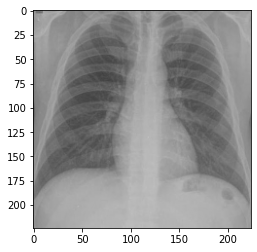

In [ ]:
# read data.
from sklearn.utils import shuffle
# from skimage import exposure


# def get_clahe(img):
#   return exposure.equalize_adapthist(img/255, kernel_size=25)


data_train = np.load("train_lung_cls.npz")
data_test = np.load("test_lung_cls.npz")
X_train, y_train = data_train["x_train"], data_train["y_train"]
X_test, y_test = data_test["x_test"], data_test["y_test"]

# X_train, y_train = X_train[:50]

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

X_train = np.ndarray.astype(X_train, np.double)
y_train = np.ndarray.astype(y_train, np.double)
X_test = np.ndarray.astype(X_test, np.double)
y_test= np.ndarray.astype(y_test, np.double)

# for i, img in enumerate(X_train):
#   X_train[i] = X_train[i]/255
# for i, img in enumerate(X_test):
#   X_test[i] = X_test[i]/255
# for i, img in enumerate(X_train):
#   X_train[i] = get_clahe(img)
# for i, img in enumerate(X_test):
#   X_test[i] = get_clahe(img)
plt.imshow(X_train[0]/255)
# print(y_train[500:700])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_test.dtype)
# print(y_test)

# Sampling

In [ ]:
x_train_0 = np.zeros([20, 224, 224, 3])
x_train_1 = np.zeros([20, 224, 224, 3])
x_train_2 = np.zeros([20, 224, 224, 3])
x_train_3 = np.zeros([20, 224, 224, 3])
y_train_0 = np.zeros([20])
y_train_1 = np.zeros([20])
y_train_2 = np.zeros([20])
y_train_3 = np.zeros([20])

l0 = 0
l1 = 0
l2 = 0
l3 = 0
for x, l in zip(X_train, y_train):
  if l == 0:
    if l0 == 20:
      continue
    x_train_0[l0] = x
    y_train_0[l0] = l
    l0 += 1
  elif l == 1:
    if l1 == 20:
      continue
    x_train_1[l1] = x
    y_train_1[l1] = l
    l1 += 1
  elif l == 2:
    if l2 == 20:
      continue
    x_train_2[l2] = x
    y_train_2[l2] = l
    l2 += 1
  else:
    if l3 == 20:
      continue
    x_train_3[l3] = x
    y_train_3[l3] = l
    l3 += 1

print(x_train_0.shape, y_train_0.shape)
print(x_train_1.shape, y_train_1.shape)
print(x_train_2.shape, y_train_2.shape)
print(x_train_3.shape, y_train_3.shape)

X_train = np.concatenate(([x_train_0, x_train_1, x_train_2, x_train_3]), axis=0)
y_train = np.concatenate(([y_train_0, y_train_1, y_train_2, y_train_3]), axis=0)
print(X_train.shape, y_train.shape)


x_test_0 = np.zeros([140, 224, 224, 3])
x_test_1 = np.zeros([140, 224, 224, 3])
x_test_2 = np.zeros([140, 224, 224, 3])
x_test_3 = np.zeros([140, 224, 224, 3])
y_test_0 = np.zeros([140])
y_test_1 = np.zeros([140])
y_test_2 = np.zeros([140])
y_test_3 = np.zeros([140])


l0 = 0
l1 = 0
l2 = 0
l3 = 0
for x, l in zip(X_test, y_test):
  if l == 0:
    if l0 == 140:
      continue
    x_test_0[l0] = x
    y_test_0[l0] = l
    l0 += 1
  elif l == 1:
    if l1 == 140:
      continue
    x_test_1[l1] = x
    y_test_1[l1] = l
    l1 += 1
  elif l == 2:
    if l2 == 140:
      continue
    x_test_2[l2] = x
    y_test_2[l2] = l
    l2 += 1
  else:
    if l3 == 140:
      continue
    x_test_3[l3] = x
    y_test_3[l3] = l
    l3 += 1

print(x_test_0.shape, y_test_0.shape)
print(x_test_1.shape, y_test_1.shape)
print(x_test_2.shape, y_test_2.shape)
print(x_test_3.shape, y_test_3.shape)

X_test = np.concatenate(([x_test_0, x_test_1, x_test_2, x_test_3]), axis=0)
y_test = np.concatenate(([y_test_0, y_test_1, y_test_2, y_test_3]), axis=0)
print(X_test.shape, y_test.shape)

d_train = {
  "x_train": X_train,
  "y_train": y_train
}
np.savez("train_few.npz", **d_train)
d_test = {
  "x_test": X_test,
  "y_test": y_test
}
np.savez("test_few.npz", **d_test)


(20, 224, 224, 3) (20,)
(20, 224, 224, 3) (20,)
(20, 224, 224, 3) (20,)
(20, 224, 224, 3) (20,)
(80, 224, 224, 3) (80,)
(140, 224, 224, 3) (140,)
(140, 224, 224, 3) (140,)
(140, 224, 224, 3) (140,)
(140, 224, 224, 3) (140,)
(560, 224, 224, 3) (560,)


# create pairs

In [ ]:
def create_pairs(data, digit_indices):
    x0_data = []
    x1_data = []
    label = []
    # print([len(digit_indices[d]) for d in range(1)])
    n = min([len(digit_indices[d]) for d in range(4)]) - 1  # n is the data with the least number of labels.
    for d in range(4): # for MNIST dataset: as we have 10 digits  (should be 4 in our condition)
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            x0_data.append(data[z1]/255.) # Image Preprocessing Step
            x1_data.append(data[z2]/255.) # Image Preprocessing Step
            label.append(1)
            inc = random.randrange(1, 5)  # random int between 1 and 4.
            dn = (d + inc) % 4
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            x0_data.append(data[z1]/255.) # Image Preprocessing Step
            x1_data.append(data[z2]/255.) # Image Preprocessing Step
            label.append(0)

    x0_data = np.array(x0_data, dtype=np.float32) #[:10201]
    # print (x0_data.shape)
    x0_data = x0_data.reshape([-1, 3, 224, 224])
    x1_data = np.array(x1_data, dtype=np.float32) #[:10201]
    x1_data = x1_data.reshape([-1, 3, 224, 224])
    label = np.array(label, dtype=np.int32)
    # print (label.shape)
    return x0_data, x1_data, label

def create_iterator(data, label, batchsize, shuffle=False):
#     print ("max label", max(label))
    # get index of data for each label.
    digit_indices = [np.where(label == i)[0] for i in range(int(np.max(label))+1)]
    # print(len(digit_indices))
    x0, x1, label = create_pairs(data, digit_indices)
    # x0, x1, label = x0[:50], x1[:50], label[:50]
    print(x0.shape)
    print(x1.shape)
    ret = Dataset(x0, x1, label)
    return ret

In [ ]:
# X_train = X_train.tolist()
# y_train = y_train.tolist()
# X_test = X_test.tolist()
# y_test = y_test.tolist()
train_iter = create_iterator(X_train,y_train,8)
test_iter = create_iterator(X_test,y_test,8)

(2736, 3, 224, 224)
(2736, 3, 224, 224)
(1112, 3, 224, 224)
(1112, 3, 224, 224)


# Loss


In [ ]:
def contrastive_loss_function(x0, x1, y, margin=1.0):
    # euclidean distance
    diff = x0 - x1
    dist_sq = torch.sum(torch.pow(diff, 2), 1)
    dist = torch.sqrt(dist_sq)
    mdist = margin - dist
    dist = torch.clamp(mdist, min=0.0)
    loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
    loss = torch.sum(loss) / 2.0 / x0.size()[0]
    return loss

def triplet_loss(positive, negative, anchor, size_average=True, margin=1.0):
    distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
    distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
    losses = F.relu(distance_positive - distance_negative + margin)
    return losses.mean() if size_average else losses.sum()

# Train


In [ ]:
batchsize = 8
import copy

class SiameseNetwork_DenseNet121(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    DenseNet 121 from Pytorch library
    """ 
    def __init__(self):
        super(SiameseNetwork_DenseNet121, self).__init__()
        # originally densenet121.
        self.cnn0 = torch.hub.load('pytorch/vision:v0.5.0', 'densenet121', pretrained=True)
        # map last layer from 1000 node outcome to three nodes
        num_ftr = self.cnn0.classifier.in_features
        # print(num_ftr)
        self.cnn0.classifier = nn.Linear(num_ftr, 500) # mapping input image to a 3D space
        # print(self.cnn0.classifier.out_features)
        # for param in self.parameters():
        #   print(param.shape)
    def forward_once(self, x):
        output = self.cnn0(x)
        return output

    def forward(self, input0, input1):
        output0 = self.forward_once(input0)
        output1 = self.forward_once(input1)
        return output0, output1

In [ ]:
# call model
model = SiameseNetwork_DenseNet121()
# model = torch.load('./Pre-epoch-9.pth')
# model.eval()
learning_rate = 0.0001 # learning rate for optimization
momentum = 0.9 # momentum

# Loss and Optimizer
criterion =  contrastive_loss_function
#contrastive_loss_function # we will use contrastive loss function as defined above
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, verbose=True)
# creating a train loader, and a test loader.
train_loader = torch.utils.data.DataLoader(train_iter,batch_size=batchsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_iter,batch_size=8, shuffle=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [ ]:
train_loss = []
epochs = 10
for epoch in range(epochs):
    total_loss = 0.0
    for batch_idx, (x0, x1, labels) in enumerate(train_loader):
        labels = labels.float()
        x0, x1, labels = Variable(x0), Variable(x1), Variable(labels)
        output1, output2 = model.forward(x0, x1)
        loss = criterion(output1, output2, labels)
        train_loss.append(loss.item())
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step(epoch)
    print('Epoch: {} \tLoss: {:.6f}'.format(epoch, total_loss*1.0/batchsize))
    torch.save(model, './500-epoch-%s.pth' % epoch)

Epoch: 0 	Loss: 106.230469
Epoch: 1 	Loss: 8.042504
Epoch: 2 	Loss: 6.704923
Epoch: 3 	Loss: 6.417121
Epoch: 4 	Loss: 6.304630
Epoch: 5 	Loss: 6.237858


KeyboardInterrupt: ignored

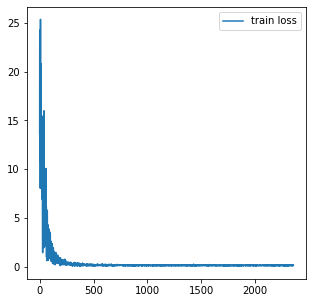

In [ ]:

# test.
# losses = []
# for batch_idx, (x0, x1, labels) in enumerate(test_loader):
#       labels = labels.float()
#       x0, x1, labels = Variable(x0), Variable(x1), Variable(labels)
#       output1, output2 = model.forward(x0, x1)
#       loss = criterion(output1, output2, labels)
#       losses.append(loss.item())

# for loss in losses:
#   print(loss)
      # total_loss += loss.item()
    #     optimizer.zero_grad()
    #     loss.backward()
    #     optimizer.step()
    # scheduler.step(epoch)



def plot_loss(train_loss,name="train_loss.png"):
    plt.plot(train_loss, label="train loss")
    plt.legend()
plot_loss(train_loss)
def plot_mnist(numpy_all, numpy_labels,name="./embeddings_plot.png"):
        c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
             '#ff00ff', '#990000', '#999900', '#009900', '#009999', '#000fff']
        for i in range(0,2):
            f = numpy_all[np.where(numpy_labels == i)]
            plt.plot(f[:, 0], f[:, 1], '.', c=c[i])
        plt.legend(['0', '1'])
        plt.savefig(name)

def visualize_scatter(data_2d, label_ids, figsize=(20,20)):
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    
    for label_id in np.unique(label_ids):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth='1',
                    alpha=0.8,
                    label={0: "negative", 1: "typical", 2: "indeterminate", 3: "atypical"})


In [ ]:

label_to_id_dict = {v:i for i,v in enumerate(np.unique(y_test))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

label_ids = np.array([label_to_id_dict[x] for x in y_test])

# Testing

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


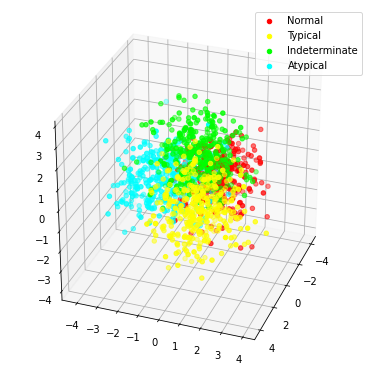

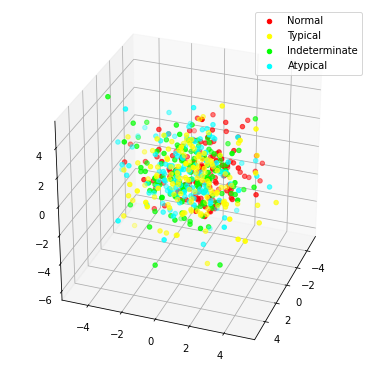

accuracy:  0.32857142857142857
recall:  0.32857142857142857
F1:  0.3312814008773865
Precision:  0.33522964015151513
[[ 1.54601993  0.74366648 -0.75984509]
 [ 0.15443234  0.33118173  1.46299092]
 [ 0.03290017 -1.80552126 -0.25351198]
 [-1.60444297  0.60181986 -0.58003074]]
accuracy:  0.22857142857142856
recall:  0.22857142857142856
F1:  0.22758653082737756
Precision:  0.22715594623398172
accuracy:  0.2785714285714286
recall:  0.2785714285714286
F1:  0.2792069447399382
Precision:  0.2822296041966449


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, recall_score, f1_score, precision_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
# from sklearn.decomposition import LatentDirichletAllocation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm

X_test = X_test/255.
y_test = np.array(y_test, dtype=np.int32)
# /content/drive/MyDrive/Colab Notebooks/Covid-19-Detection-Few-Shot-Learning/Dense121-epoch-9.pth
model = torch.load("./500-epoch-2.pth")
# model.eval()
# print(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

def test_model(model):
        # model.eval()
        all_ = []
        all_labels = []
        with torch.no_grad():
            for i in range(0, 1372):
                x = Variable(torch.tensor(X_train[i].reshape([-1, 3, 224, 224]), dtype=torch.float32).to(device))
                y_t = np.array(y_train[i], dtype=np.int32)
                y = Variable(torch.tensor(y_t).to(device))
                # print(x.dtype)
                output = model.forward_once(x)
                all_.extend(output.data.cpu().numpy().tolist())
                all_labels.append(y.data.cpu().numpy().tolist())

        numpy_all = np.array(all_)
        numpy_labels = np.array(all_labels)
        return numpy_all, numpy_labels

def testing_plots(model):
        dict_pickle={}
        numpy_all, numpy_labels = test_model(model)
        dict_pickle["numpy_all"]=numpy_all
        dict_pickle["numpy_labels"]=numpy_labels

        # pca = PCA(n_components=100)
        # pca_result = pca.fit_transform(numpy_all)

        # tsne = TSNE(n_components=3, perplexity=10.0)
        # tsne_result = tsne.fit_transform(pca_result)
        # lda_result = StandardScaler().fit_transform(tsne_result)

        lda = LinearDiscriminantAnalysis(n_components=3)
        lda.fit(numpy_all,numpy_labels)
        lda_result = lda.fit_transform(numpy_all, numpy_labels)
        fig = plt.figure()
        ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
        c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
             '#ff00ff', '#990000', '#999900', '#009900', '#009999', '#000fff']
        for i in range (4):
          f = lda_result[np.where(numpy_labels == i)]
          ax.scatter(f[:, 0], f[:, 1], f[:, 2],marker='o',c=c[i])
        
        plt.legend(["Normal", "Typical", "Indeterminate", "Atypical"])  
        plt.show()




        clusterer = KMeans(n_clusters=4)
        km = clusterer.fit(lda_result)

        gm = GaussianMixture(n_components=4, random_state=0)
        gm_res = gm.fit(lda_result)

        clf = svm.SVC()
        svm_result = clf.fit(lda_result, numpy_labels)
        # train_result = clf.predict(numpy_all)
        # print("accuracy: ", accuracy_score(numpy_labels, train_result))
        # print("recall: ", recall_score(numpy_labels, train_result, average='macro'))
        # print("F1: ", f1_score(numpy_labels, train_result, average='macro'))
        # print("Precision: ", precision_score(numpy_labels, train_result, average='macro'))

        all_test_ = []
        all_test_labels = []
        with torch.no_grad():
            for i in range(0, 560):
                x = Variable(torch.tensor(X_test[i].reshape([-1, 3, 224, 224]), dtype=torch.float32).to(device))
                y_t = np.array(y_test[i], dtype=np.int32)
                y = Variable(torch.tensor(y_t).to(device))
                # print(x.dtype)
                output = model.forward_once(x)
                all_test_.extend(output.data.cpu().numpy().tolist())
                all_test_labels.append(y.data.cpu().numpy().tolist())


        test_all = np.array(all_test_)
        test_labels = np.array(all_test_labels)
        # print(test_all.shape)
        # print(test_labels)
        # lda = LinearDiscriminantAnalysis(n_components=3)
        # lda_test.fit(test_all,test_labels)

        # pca_res = pca.transform(test_all)
        # lda_test_result = tsne.fit_transform(pca_res)
        lda_test_result = lda.transform(test_all)

        fig = plt.figure()
        ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
        c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
             '#ff00ff', '#990000', '#999900', '#009900', '#009999', '#000fff']
        for i in range (4):
          f = lda_test_result[np.where(test_labels == i)]
          ax.scatter(f[:, 0], f[:, 1], f[:, 2],marker='o',c=c[i])
        
        plt.legend(["Normal", "Typical", "Indeterminate", "Atypical"])  
        plt.show()


        cls_result = clf.predict(lda_test_result)

        print("accuracy: ", accuracy_score(test_labels, cls_result))
        print("recall: ", recall_score(test_labels, cls_result, average='macro'))
        print("F1: ", f1_score(test_labels, cls_result, average='macro'))
        print("Precision: ", precision_score(test_labels, cls_result, average='macro'))

        # print(tsne_result_scaled.shape)
        # visualize_scatter(tsne_result_scaled, numpy_labels)
        
        preds = km.predict(lda_test_result)
        centers = km.cluster_centers_
        print(centers)
        
        preds_g = gm.predict(lda_test_result)
        # print("silhouette score: ", silhouette_score(lda_test_result, preds))
        print("accuracy: ", accuracy_score(test_labels, preds))
        print("recall: ", recall_score(test_labels, preds, average='macro'))
        print("F1: ", f1_score(test_labels, preds, average='macro'))
        print("Precision: ", precision_score(test_labels, preds, average='macro'))


        print("accuracy: ", accuracy_score(test_labels, preds_g))
        print("recall: ", recall_score(test_labels, preds_g, average='macro'))
        print("F1: ", f1_score(test_labels, preds_g, average='macro'))
        print("Precision: ", precision_score(test_labels, preds_g, average='macro'))


        # print (score)$
        
        # plot_mnist(lda_test_result, test_labels)

from sklearn.metrics import silhouette_samples, silhouette_score
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
testing_plots(model)

In [ ]:
train_result = clf.predict(numpy_all)
print("accuracy: ", accuracy_score(numpy_labels, train_result))
print("recall: ", recall_score(numpy_labels, train_result, average='macro'))
print("F1: ", f1_score(numpy_labels, train_result, average='macro'))
print("Precision: ", precision_score(numpy_labels, train_result, average='macro'))

NameError: ignored

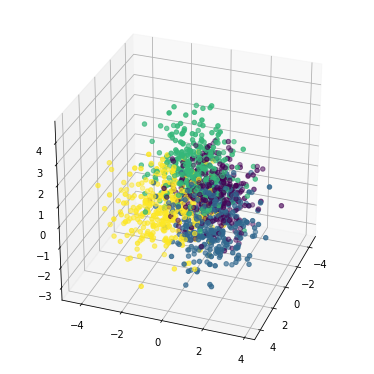

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, recall_score, f1_score, precision_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
# from sklearn.decomposition import LatentDirichletAllocation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm

X_test = X_test/255.
y_test = np.array(y_test, dtype=np.int32)
# /content/drive/MyDrive/Colab Notebooks/Covid-19-Detection-Few-Shot-Learning/Dense121-epoch-9.pth
model = torch.load("./Dense121-epoch-9.pth")
# model.eval()
# print(model)
def test_model(model):
        # model.eval()
        all_ = []
        all_labels = []
        with torch.no_grad():
            for i in range(0, 1372):
                x = Variable(torch.tensor(X_train[i].reshape([-1, 3, 224, 224]), dtype=torch.float32))
                y_t = np.array(y_train[i], dtype=np.int32)
                y = Variable(torch.tensor(y_t))
                # print(x.dtype)
                output = model.forward_once(x)
                all_.extend(output.data.cpu().numpy().tolist())
                all_labels.append(y.data.cpu().numpy().tolist())

        numpy_all = np.array(all_)
        numpy_labels = np.array(all_labels)
        return numpy_all, numpy_labels

def testing_plots(model):
        dict_pickle={}
        numpy_all, numpy_labels = test_model(model)
        dict_pickle["numpy_all"]=numpy_all
        dict_pickle["numpy_labels"]=numpy_labels

        # pca = PCA(n_components=180)
        # pca_result = pca.fit_transform(numpy_all)

        # tsne = TSNE(n_components=2, perplexity=10.0)
        # tsne_result = tsne.fit_transform(pca_result)
        # tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

        lda = LinearDiscriminantAnalysis(n_components=3)
        lda.fit(numpy_all,numpy_labels)
        lda_result = lda.transform(numpy_all)
        fig = plt.figure()
        ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
        ax.scatter(lda_result[:, 0], lda_result[:, 1], lda_result[:, 2],marker='o',c=numpy_labels)
        plt.show()

        # clf = svm.SVC()
        # svm_result = clf.fit(numpy_all, numpy_labels)


        # all_test_ = []
        # all_test_labels = []
        # with torch.no_grad():
        #     for i in range(0, 560):
        #         x = Variable(torch.tensor(X_test[i].reshape([-1, 3, 224, 224]), dtype=torch.float32))
        #         y_t = np.array(y_test[i], dtype=np.int32)
        #         y = Variable(torch.tensor(y_t))
        #         # print(x.dtype)
        #         output = model.forward_once(x)
        #         all_test_.extend(output.data.cpu().numpy().tolist())
        #         all_test_labels.append(y.data.cpu().numpy().tolist())


        # test_all = np.array(all_test_)
        # test_labels = np.array(all_test_)

        # lda_test = LinearDiscriminantAnalysis(n_components=20)
        # lda_test.fit(test_all,test_labels)
        # lda_test_result = lda_test.transform(test_all)

        # cls_result = clf.predict(test_all)

        # print("accuracy: ", accuracy_score(test_labels, cls_result))
        # print("recall: ", recall_score(test_labels, cls_result, average='macro'))
        # print("F1: ", f1_score(test_labels, cls_result, average='macro'))
        # print("Precision: ", precision_score(test_labels, cls_result, average='macro'))

        # print(tsne_result_scaled.shape)
        # visualize_scatter(tsne_result_scaled, numpy_labels)
        # clusterer = KMeans(n_clusters=4)
        # preds = clusterer.fit_predict(lda_result)
        # centers = clusterer.cluster_centers_
        # gm = GaussianMixture(n_components=2, random_state=0).fit(tsne_result_scaled)
        # preds = gm.predict(tsne_result_scaled)
        # print("silhouette score: ", silhouette_score(tsne_result_scaled, preds))
        # print("accuracy: ", accuracy_score(numpy_labels, preds))
        # print("recall: ", recall_score(numpy_labels, preds, average='macro'))
        # print("F1: ", f1_score(numpy_labels, preds, average='macro'))
        # print("Precision: ", precision_score(numpy_labels, preds, average='macro'))

        # print (score)
        
        # plot_mnist(tsne_result_scaled, numpy_labels)

from sklearn.metrics import silhouette_samples, silhouette_score
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
testing_plots(model)

# Feature compression

In [ ]:
train_result = clf.predict(numpy_all)
print("accuracy: ", accuracy_score(numpy_labels, train_result))
print("recall: ", recall_score(numpy_labels, train_result, average='macro'))
print("F1: ", f1_score(numpy_labels, train_result, average='macro'))
print("Precision: ", precision_score(numpy_labels, train_result, average='macro'))

NameError: ignored